[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/line_detection_and_matching_sold2.ipynb)

# Line detection and matching example with SOLD2: Self-supervised Occlusion-aware Line Description and Detection

In this tutorial we will show how we can quickly perform line detection, and matching using [`kornia.feature.sold2`](https://kornia.readthedocs.io/en/latest/feature.html#kornia.feature.SOLD2_detector) API.

## Setup

Install the libraries:

In [ ]:
%%capture
!pip install git+https://github.com/kornia/kornia
!pip install opencv-python --upgrade # Just for windows
!pip install matplotlib

Now let's download an image

In [ ]:
%%capture
!wget https://github.com/cvg/SOLD2/raw/main/assets/images/terrace0.JPG
!wget https://github.com/cvg/SOLD2/raw/main/assets/images/terrace1.JPG

Then, we will load the libraries

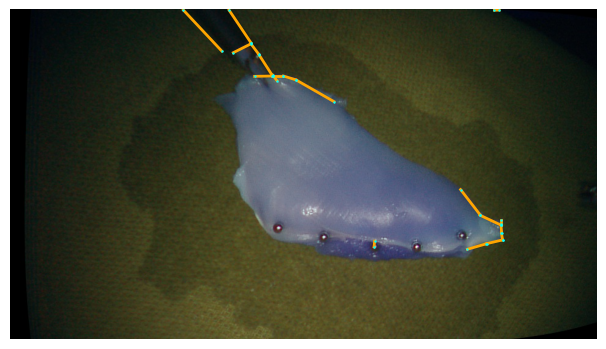

In [2]:
import kornia as K
import kornia.feature as KF
import torch
import cv2
import copy
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import time

def plot_images(imgs, titles=None, cmaps="gray", dpi=100, size=6, pad=0.5):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n
    figsize = (size * n, size * 3 / 4) if size is not None else None
    fig, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
    fig.tight_layout(pad=pad)


def plot_lines(
    lines, line_colors="orange", point_colors="cyan", ps=4, lw=2, indices=(0, 1)
):
    """Plot lines and endpoints for existing images.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        colors: string, or list of list of tuples (one for each keypoints).
        ps: size of the keypoints as float pixels.
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    if not isinstance(line_colors, list):
        line_colors = [line_colors] * len(lines)
    if not isinstance(point_colors, list):
        point_colors = [point_colors] * len(lines)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l, lc, pc in zip(axes, lines, line_colors, point_colors):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=lc,
                linewidth=lw,
            )
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 1], pts[:, 0], c=pc, s=ps, linewidths=0, zorder=2)


def plot_color_line_matches(lines, lw=2, indices=(0, 1)):
    """Plot line matches for existing images with multiple colors.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    n_lines = len(lines[0])

    cmap = plt.get_cmap("nipy_spectral", lut=n_lines)
    colors = np.array([mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)])

    np.random.shuffle(colors)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=colors[i],
                linewidth=lw,
            )
            a.add_line(line)

fname1 = 'fei_ref_data/ref_left_img.jpg'
fname2 = 'fei_ref_data/ref_right_img.jpg'
#fname1 = 'ref_data/no_contour/crop_ref_l_img.npy'
#fname2 = 'ref_data/no_contour/crop_ref_r_img.npy'

torch_img1 = cv2.imread(fname1, cv2.IMREAD_COLOR)
torch_img1 = cv2.cvtColor(torch_img1, cv2.COLOR_BGR2RGB)
torch_tensor1 = K.image_to_tensor(torch_img1).float() / 255.0
#torch_tensor1 = K.image_to_tensor(fname1).float() / 255.0

torch_img2 = cv2.imread(fname2, cv2.IMREAD_COLOR)
torch_img2 = cv2.cvtColor(torch_img2, cv2.COLOR_BGR2RGB)
torch_tensor2 = K.image_to_tensor(torch_img2).float() / 255.0
#torch_tensor2 = K.image_to_tensor(fname2).float() / 255.0

imgs_to_plot = [K.tensor_to_image(torch_tensor1), K.tensor_to_image(torch_tensor2)]
#plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])


torch_tensor1 = K.enhance.sharpness(torch_tensor1, 5.0)
torch_tensor2 = K.enhance.sharpness(torch_tensor2, 5.0)
torch_tensor1 = K.enhance.adjust_saturation(torch_tensor1, 5.0)
torch_tensor2 = K.enhance.adjust_saturation(torch_tensor2, 5.0)

#torch_img1 = K.enhance.equalize_clahe(torch_img1)
#torch_img2 = K.enhance.equalize_clahe(torch_img2)
#torch_img1 = K.enhance.invert(torch_img1)
#torch_img2 = K.enhance.invert(torch_img2)
#torch_img1 = K.enhance.adjust_sigmoid(torch_img1, cutoff = 0.05, gain = 10, inv = False)
#torch_img2 = K.enhance.adjust_sigmoid(torch_img2, cutoff = 0.05, gain = 10, inv = False)
#torch_img1 = K.filters.sobel(torch_img1[None, :, :, :])
#torch_img2 = K.filters.sobel(torch_img2[None, :, :, :])
#torch_img1 = K.filters.laplacian(torch_img1[None, :, :, :], 5)
#torch_img2 = K.filters.laplacian(torch_img2[None, :, :, :], 5)
#torch_img1 = K.filters.bilateral_blur(torch_img1, (3, 3), 0.1, (1.5, 1.5))
#torch_img2 = K.filters.bilateral_blur(torch_img2, (3, 3), 0.1, (1.5, 1.5))
#torch_img1 = K.filters.unsharp_mask(torch_img1[None, :, :, :], (3, 3), (5, 5))
#torch_img2 = K.filters.unsharp_mask(torch_img2[None, :, :, :], (3, 3), (5, 5))

imgs_to_plot = [K.tensor_to_image(torch_tensor1), K.tensor_to_image(torch_tensor2)]
#plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])

#torch_img1 = torch.squeeze(torch_img1)
#torch_img2 = torch.squeeze(torch_img2)
# First, convert the images to gray scale
torch_tensor1_gray = K.color.rgb_to_grayscale(torch_tensor1)
torch_tensor2_gray = K.color.rgb_to_grayscale(torch_tensor2)

# then, stack the images to create/simulate a batch
imgs = torch.stack(
    [torch_tensor1_gray, torch_tensor2_gray],
)

sold2 = KF.SOLD2(pretrained=True, config=None)

with torch.inference_mode():
    outputs = sold2(imgs)

line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]
heatmap1 = outputs["line_heatmap"][0]
heatmap2 = outputs["line_heatmap"][1]

with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])
valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = line_seg1[valid_matches]
matched_lines2 = line_seg2[match_indices]

#imgs_to_plot = [K.tensor_to_image(torch_tensor1), K.tensor_to_image(torch_tensor2)]
#imgs_to_plot = [K.tensor_to_image(torch_tensor1)]
imgs_to_plot = [torch_img1]
#out_img = K.tensor_to_image(torch_tensor1)
#cv2.imwrite('dtd_sold2linedetection.png', out_img)
#plt.imsave('dtd_sold2linedetection.png', out_img)
#lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]
lines_to_plot = [line_seg1.numpy()]

#plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
#plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})

plot_images(imgs_to_plot)
plot_lines(lines_to_plot, ps=3, lw=2, indices={0})

#plt.axis('off')
#plt.imshow(heatmap1)



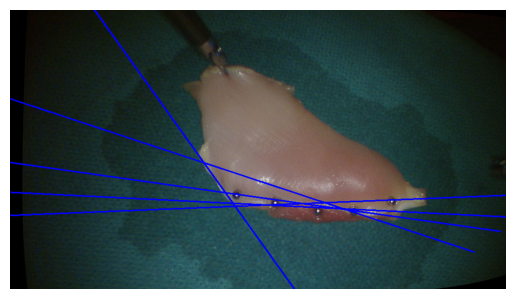

In [49]:
import cv2
  
img = cv2.imread('fei_ref_data/ref_left_img.jpg')  # Read image
  
# Setting parameter values
t_lower = 100  # Lower Threshold
t_upper = 200 # Upper threshold
  
# Applying the Canny Edge filter
edges = cv2.Canny(img, t_lower, t_upper)

plt.axis('off')
plt.imshow(edges)
import math
lines = cv2.HoughLinesWithAccumulator(edges, rho = 5, theta = 0.09, threshold = 145) 
lines = np.squeeze(lines)
# sort by max votes
sorted_lines = lines[(-lines[:, 2]).argsort()]
for i in range(sorted_lines.shape[0]):
    rho = sorted_lines[i, 0]
    theta = sorted_lines[i, 1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(img, pt1, pt2, (0,0,255), 2)
plt.imshow(img)

img_height: 540
img_width: 960
sold2 line detection took 3.0494 seconds


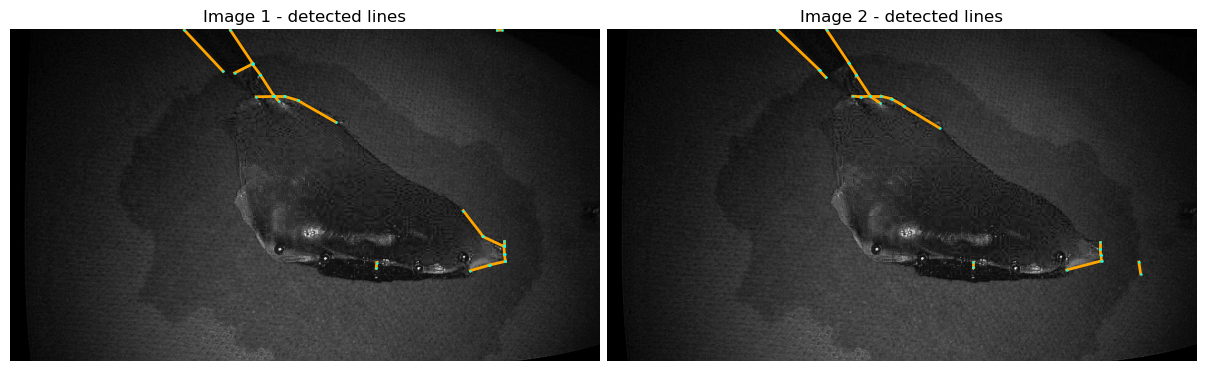

In [22]:
# load images
fname1 = 'fei_ref_data/ref_left_img.jpg'
fname2 = 'fei_ref_data/test_left_img.jpg'
ref_img = cv2.imread(fname1, cv2.IMREAD_COLOR)
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)
ref_tensor = K.image_to_tensor(ref_img).float() / 255.0  # [0, 1] [3, crop_dims] float32

non_annotated_img = cv2.imread(fname2, cv2.IMREAD_COLOR)
non_annotated_img = cv2.cvtColor(non_annotated_img, cv2.COLOR_BGR2RGB)
non_annotated_tensor = K.image_to_tensor(non_annotated_img).float() / 255.0  # [0, 1] [3, crop_dims] float32

ref_tensor = K.enhance.sharpness(ref_tensor, 5.0)
ref_tensor = K.enhance.adjust_saturation(ref_tensor, 5.0)

non_annotated_tensor = K.enhance.sharpness(non_annotated_tensor, 5.0)
non_annotated_tensor = K.enhance.adjust_saturation(non_annotated_tensor, 5.0)

# process input image
img_height = non_annotated_img.shape[0]
print('img_height: {}'.format(img_height))
img_width = non_annotated_img.shape[1]
print('img_width: {}'.format(img_width))

# convert to grayscale
ref_tensor = K.color.rgb_to_grayscale(ref_tensor) # [0, 1] [1, crop_dims] float32
non_annotated_tensor = K.color.rgb_to_grayscale(non_annotated_tensor) # [0, 1] [1, crop_dims] float32

#tensors = torch.stack([ref_tensor, non_annotated_tensor], )
tensors = torch.stack([non_annotated_tensor], )

# line detection
start_time = time.perf_counter()
with torch.inference_mode():
    outputs = sold2(tensors)

end_time = time.perf_counter()
total_time = end_time - start_time
print(f'sold2 line detection took {total_time:.4f} seconds')

# detect line segments
#line_seg1 = outputs["line_segments"][0]
#line_seg2 = outputs["line_segments"][1]
#desc1 = outputs["dense_desc"][0]
#desc2 = outputs["dense_desc"][1]
#line_heatmap1 = np.asarray(outputs['line_heatmap'][0])
#line_heatmap2 = np.asarray(outputs['line_heatmap'][1])
line_seg2 = outputs["line_segments"][0]
desc2 = outputs["dense_desc"][0]
line_heatmap2 = np.asarray(outputs['line_heatmap'][0])

#np.save('fei_ref_data/crop_ref_lines_r.npy', line_seg1)
#np.save('fei_ref_data/crop_ref_desc_r.npy', desc1)

line_seg1 = np.load('fei_ref_data/crop_ref_lines_l.npy')
line_seg1 = torch.tensor(line_seg1)
desc1 = np.load('fei_ref_data/crop_ref_desc_l.npy')
desc1 = torch.tensor(desc1)

imgs_to_plot = [K.tensor_to_image(ref_tensor), K.tensor_to_image(non_annotated_tensor)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})


sold2 line matching took 0.0952 seconds


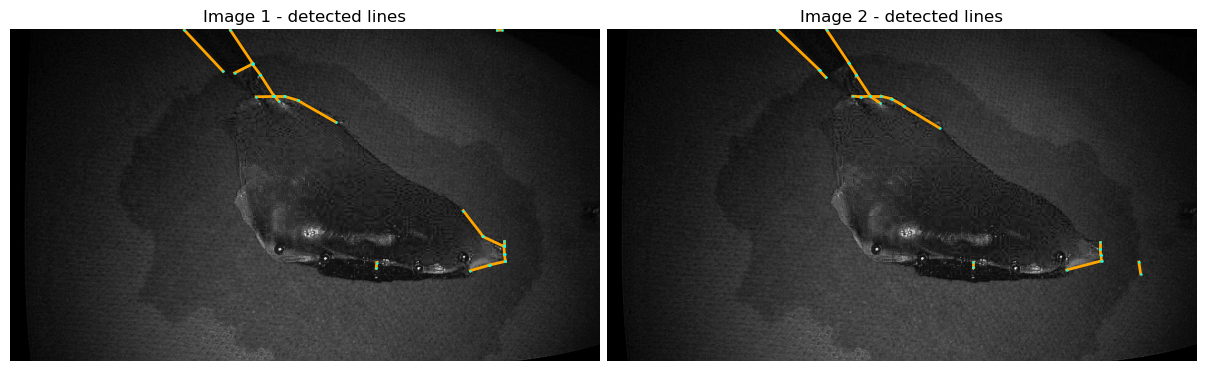

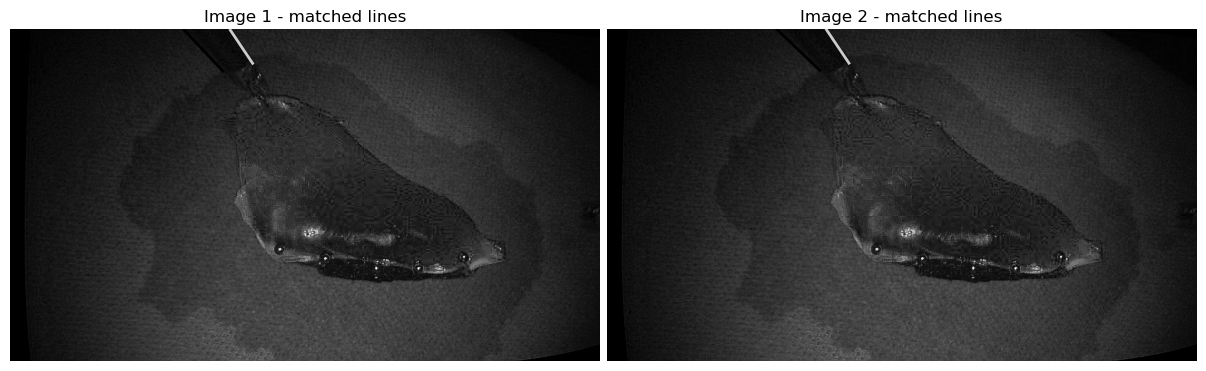

In [23]:
# perform association between All line segments 
# in ref_img and new_img
start_time = time.perf_counter()
with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])
end_time = time.perf_counter()
total_time = end_time - start_time
print(f'sold2 line matching took {total_time:.4f} seconds')
valid_matches = matches != -1

# match by reference line index
#crop_ref_lines_idx = np.asarray([0, 1])
#np.save('fei_ref_data/crop_ref_lines_l_idx.npy', crop_ref_lines_idx)
crop_ref_lines_idx = np.load('fei_ref_data/crop_ref_lines_l_idx.npy')
ref_matches_indices = []
matched_lines1 = []
matched_lines2 = []
ref_line1_idx = crop_ref_lines_idx[0]
ref_line2_idx = crop_ref_lines_idx[1]
if (valid_matches[ref_line1_idx]):
    ref_matches_indices.append(matches.numpy()[ref_line1_idx])
    matched_lines1.append(line_seg1[ref_line1_idx, :, :])
    
if (valid_matches[ref_line2_idx]):
    ref_matches_indices.append(matches.numpy()[ref_line2_idx])
    matched_lines1.append(line_seg1[ref_line2_idx, :, :])

if (matched_lines1):
    matched_lines1 = torch.stack(matched_lines1)
    matched_lines2 = line_seg2[ref_matches_indices]

imgs_to_plot = [K.tensor_to_image(ref_tensor), K.tensor_to_image(non_annotated_tensor)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})

# select only matching line segments that correspond to ref lines
#if (draw_lines):
    #annotated_img = drawLineSegments(annotated_img, matched_lines2)

# kornia detected endpoints
#detected_endpoints = np.asarray(np.around(np.asarray(matched_lines2), decimals = 0), dtype = int) # [[y, x], [y, x]]
# draw endpoints
#annotated_img = drawPoints(annotated_img, detected_endpoints)

plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([matched_lines1, matched_lines2], lw=2)

In [6]:
crop_scale= np.load('fei_ref_data/crop_scale.npy')
print(crop_scale)
crop_scale = 1
np.save('fei_ref_data/crop_scale.npy', crop_scale)
crop_scale= np.load('fei_ref_data/crop_scale.npy')
print(crop_scale)

0.5
1


In [17]:
import copy

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np


def plot_images(imgs, titles=None, cmaps="gray", dpi=100, size=6, pad=0.5):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n
    figsize = (size * n, size * 3 / 4) if size is not None else None
    fig, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
    fig.tight_layout(pad=pad)


def plot_lines(
    lines, line_colors="orange", point_colors="cyan", ps=4, lw=2, indices=(0, 1)
):
    """Plot lines and endpoints for existing images.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        colors: string, or list of list of tuples (one for each keypoints).
        ps: size of the keypoints as float pixels.
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    if not isinstance(line_colors, list):
        line_colors = [line_colors] * len(lines)
    if not isinstance(point_colors, list):
        point_colors = [point_colors] * len(lines)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l, lc, pc in zip(axes, lines, line_colors, point_colors):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=lc,
                linewidth=lw,
            )
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 1], pts[:, 0], c=pc, s=ps, linewidths=0, zorder=2)


def plot_color_line_matches(lines, lw=2, indices=(0, 1)):
    """Plot line matches for existing images with multiple colors.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    n_lines = len(lines[0])

    cmap = plt.get_cmap("nipy_spectral", lut=n_lines)
    colors = np.array([mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)])

    np.random.shuffle(colors)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=colors[i],
                linewidth=lw,
            )
            a.add_line(line)

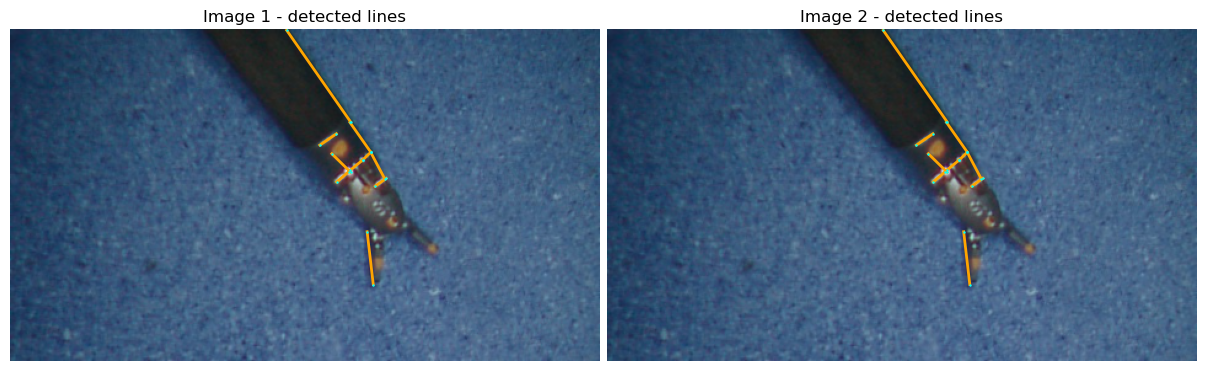

In [18]:
imgs_to_plot = [K.tensor_to_image(torch_img1), K.tensor_to_image(torch_img2)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})

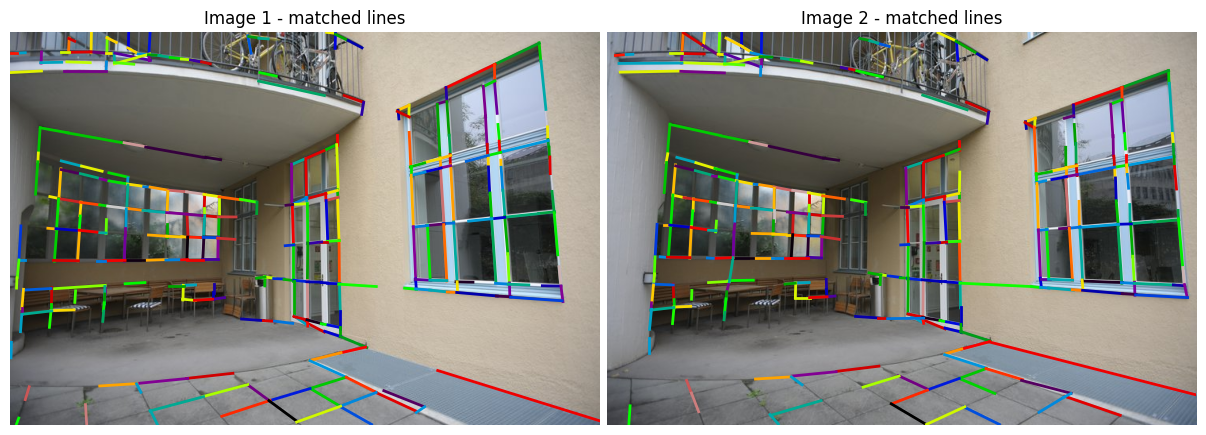

In [ ]:
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([matched_lines1, matched_lines2], lw=2)

## Example of homography from line segment correspondences from SOLD2

Robust geometry estimation with Random sample consensus (RANSAC)

Load the model:

In [ ]:
ransac = K.geometry.RANSAC(model_type="homography_from_linesegments", inl_th=3.0)

### Perform the model correspondencies

In [ ]:
H_ransac, correspondence_mask = ransac(
    matched_lines1.flip(dims=(2,)), matched_lines2.flip(dims=(2,))
)

Wrap the image 1 to image 2

In [ ]:
img1_warp_to2 = K.geometry.warp_perspective(
    torch_img1[None], H_ransac[None], (torch_img1.shape[1:])
)

### Plot the matched lines and wrapped image

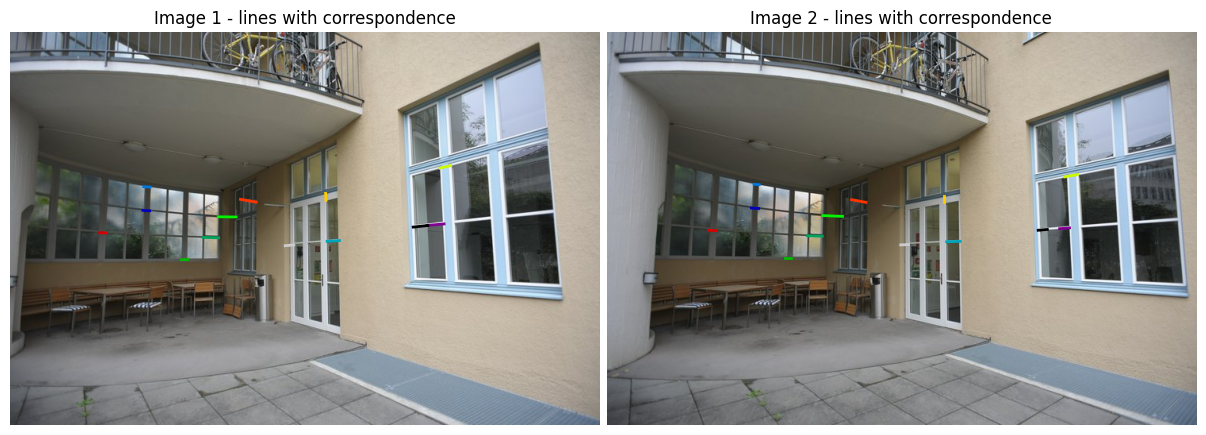

In [ ]:
plot_images(
    imgs_to_plot,
    ["Image 1 - lines with correspondence", "Image 2 - lines with correspondence"],
)
plot_color_line_matches(
    [matched_lines1[correspondence_mask], matched_lines2[correspondence_mask]], lw=2
)

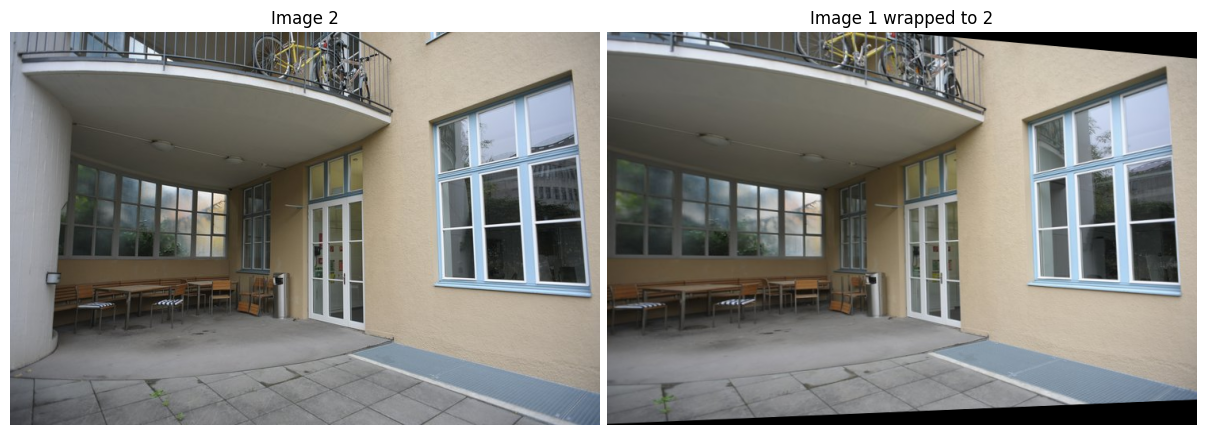

In [ ]:
plot_images(
    [K.tensor_to_image(torch_img2), K.tensor_to_image(img1_warp_to2)],
    ["Image 2", "Image 1 wrapped to 2"],
)